# Football Diffusion: End-to-End Pipeline

This notebook demonstrates:
1. Data preprocessing
2. Dataset inspection
3. Model evaluation and visualization

**Note**: Model training should be done via command-line:
```bash
python train_main.py --config src/football_diffusion/config/train.yaml
```

If you encounter PyArrow errors during preprocessing, restart the kernel (Kernel → Restart) and re-run all cells from the beginning.


In [1]:
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

# Add src to path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Force reload modules to avoid cached versions
modules_to_reload = [
    'football_diffusion.data.preprocess',
    'football_diffusion.data',
    'football_diffusion.viz',
    'football_diffusion.viz.field',
    'football_diffusion.viz.animate',
    'football_diffusion.viz.evaluate_play'
]
for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

from football_diffusion.data.preprocess import preprocess_all
from football_diffusion.data.dataset import FootballPlayDataset, collate_fn

# Import visualization functions (try from package first, fallback to direct imports)
try:
    from football_diffusion.viz import (
        plot_trajectory, 
        draw_field, 
        animate_trajectory,
        evaluate_play_quality,
        print_play_quality_report
    )
except ImportError:
    # Fallback: import directly from submodules
    print("Falling back to direct imports...")
    from football_diffusion.viz.field import plot_trajectory, draw_field
    from football_diffusion.viz.animate import animate_trajectory
    from football_diffusion.viz.evaluate_play import evaluate_play_quality, print_play_quality_report

from football_diffusion.utils.seed import set_seed

import yaml

# Set random seed for reproducibility
set_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("Modules loaded - ready for preprocessing and visualization")


PyTorch version: 2.8.0
Device: cpu
Modules loaded - ready for preprocessing and visualization


## 1. Data Preprocessing


In [2]:
# Load config and preprocess data
with open('../src/football_diffusion/config/default.yaml') as f:
    config = yaml.safe_load(f)

raw_dir = Path('../../data/nfl-big-data-bowl-2023')
cache_dir = Path('../../data/cache')
cache_dir.mkdir(parents=True, exist_ok=True)

# Check if cache file already exists
cache_file = cache_dir / 'processed_plays.pkl'
if cache_file.exists():
    print(f"✅ Cache file found at {cache_file}")
    print("   Skipping preprocessing. To re-run preprocessing, delete the cache file first.")
    print("   (Delete it by running: cache_file.unlink() in a cell)")
else:
    print("Cache file not found. Running preprocessing...")
    preprocess_all(raw_dir, cache_dir, config['data'])
    print("Preprocessing complete!")


✅ Cache file found at ../../data/cache/processed_plays.pkl
   Skipping preprocessing. To re-run preprocessing, delete the cache file first.
   (Delete it by running: cache_file.unlink() in a cell)


## 2. Load and Inspect Dataset


In [3]:
# Load datasets - use .pkl file (pickle format)
cache_file = cache_dir / 'processed_plays.pkl'
metadata_file = cache_dir / 'metadata.json'

train_dataset = FootballPlayDataset(cache_file, metadata_file, split='train')
print(f"Train: {len(train_dataset)} plays")

sample = train_dataset[0]
print(f"Sample shape: {sample['X'].shape}")
print(f"Context: {sample['context_categorical']}")


Train: 6608 plays
Sample shape: torch.Size([60, 22, 3])
Context: {'down': 3, 'offensiveFormation': 'SHOTGUN', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'DAL', 'situation': 'short'}


## 3. Model Training

**Training should be done via command-line**, not in this notebook.

Run training from the project root:
```bash
cd diffusion
python train_main.py --config src/football_diffusion/config/train.yaml \
    --cache_dir ../../data/cache \
    --output_dir ../../artifacts/diffusion \
    --gpus 1 \
    --max_epochs 50
```

Or use the provided script:
```bash
bash scripts/train_diffusion.sh
```

This will save model checkpoints to `../../artifacts/diffusion/` which can then be loaded for evaluation below.


## 4. Evaluation and Visualization


Sample play shape: torch.Size([60, 22, 3])
Context: {'down': 3, 'offensiveFormation': 'SHOTGUN', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'DAL', 'situation': 'short'}


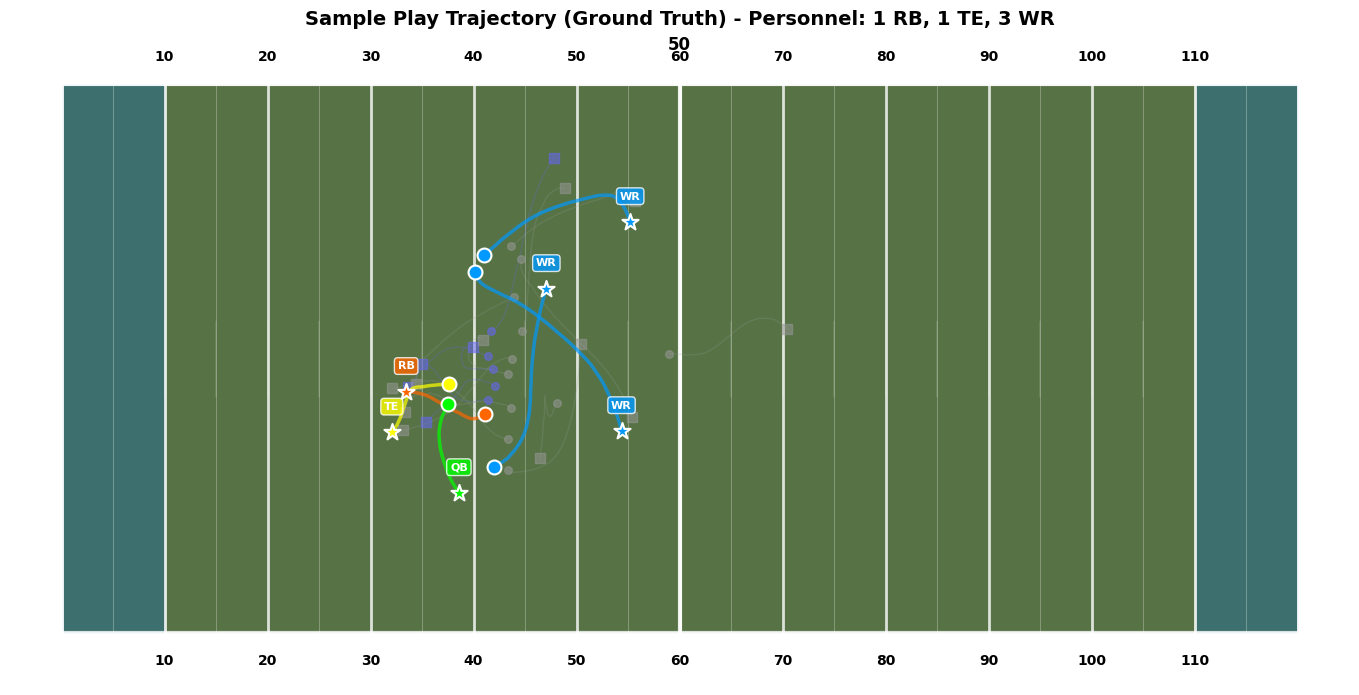


PLAY QUALITY EVALUATION
PLAY QUALITY REPORT
Overall Quality Score: 0.504

Validity Checks:
  ✓ Field Bounds:      100.0% valid
  ✓ Speed Cap:         100.0% valid
  ✓ Overall Validity:  100.0% valid

Realism Metrics:
  ✓ Smoothness:        0.987 (1.0 = perfectly smooth)
  ✓ Movement:          11.40 yards avg displacement
  ✓ Forward Progress:  0.42 yards
  ✓ Direction:         0.511 (1.0 = consistently forward)

Assessment: 🟠 FAIR


In [4]:
# Evaluation and visualization examples
# 
# To evaluate a trained model, use the command-line script:
# python -m src.football_diffusion.eval.eval_diffusion \
#     --checkpoint ../../artifacts/diffusion/best.ckpt \
#     --cache_dir ../../data/cache \
#     --config src/football_diffusion/config/eval.yaml \
#     --split test
#
# Or load a model for visualization:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example: Load a trained model (uncomment when you have a checkpoint)
# from football_diffusion.training.train_diffusion import DiffusionLightningModule
# model = DiffusionLightningModule.load_from_checkpoint(
#     '../../artifacts/diffusion/best.ckpt',
#     config=config
# )
# model.model = model.model.to(device)
# model.model.eval()

# Get a sample from the dataset for visualization
sample_play = train_dataset[0]
print(f"Sample play shape: {sample_play['X'].shape}")
print(f"Context: {sample_play['context_categorical']}")

# Visualize the ground truth trajectory with position labels
trajectory = sample_play['X'].numpy()  # [T, P, F]

# Static plot with position labels and skill position highlighting
# Use personnel string to derive correct position labels
personnel_str = sample_play['context_categorical'].get('personnelO', '')

fig, ax = plt.subplots(figsize=(14, 7))
draw_field(ax)
plot_trajectory(
    trajectory, 
    ax=ax, 
    alpha=0.7,
    highlight_skill_only=True,  # Only highlight RB, WR, TE, QB
    show_path=True,
    personnel_str=personnel_str  # Pass personnel to derive correct labels
)
ax.set_title(f'Sample Play Trajectory (Ground Truth) - Personnel: {personnel_str}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Evaluate play quality
print("\n" + "="*60)
print("PLAY QUALITY EVALUATION")
print("="*60)
quality_metrics = evaluate_play_quality(trajectory)
print_play_quality_report(quality_metrics)


In [ ]:
## 5. Animated Visualization with Position Labels

# Animate trajectories showing only skill positions (RB, WR, TE, QB) moving, 
# while keeping other players static for clarity.


SyntaxError: invalid syntax (3663192312.py, line 3)

Visualizing play 0
Context: {'down': 3, 'offensiveFormation': 'SHOTGUN', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'DAL', 'situation': 'short'}
Personnel: 1 RB, 1 TE, 3 WR
Trajectory shape: (60, 22, 3)


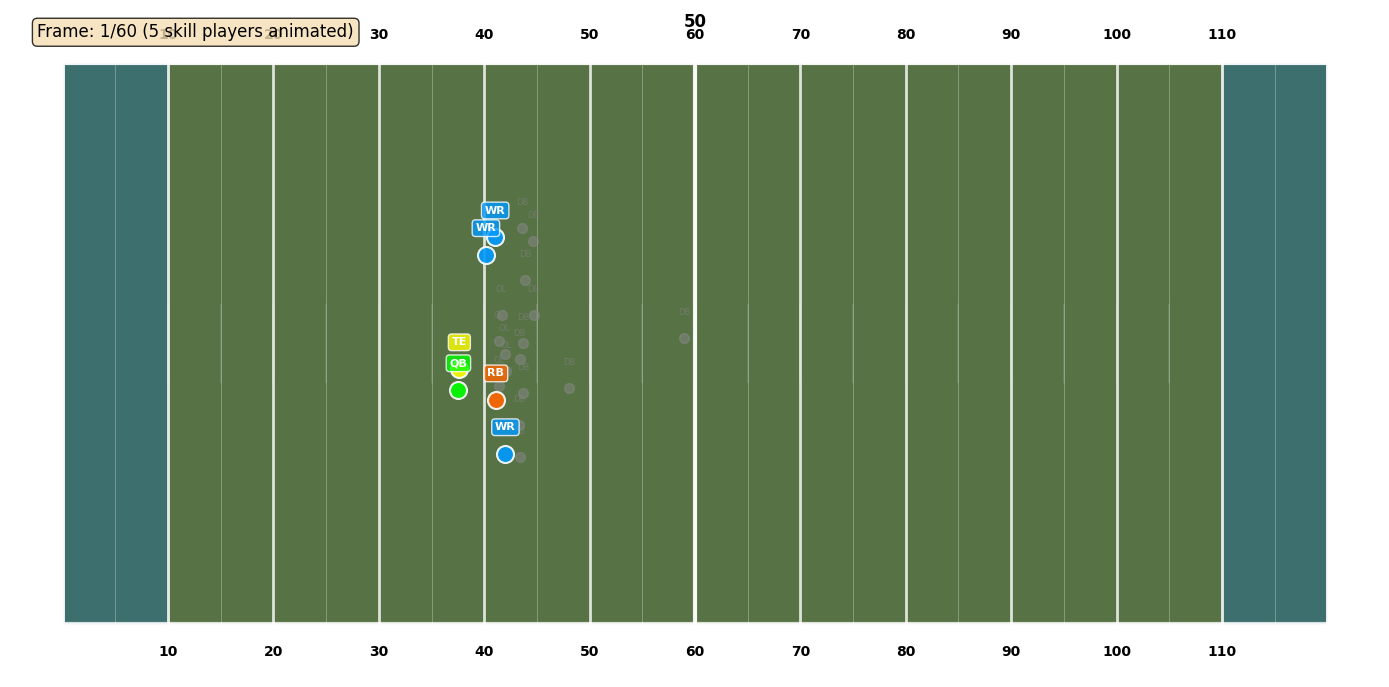

In [5]:
# Enable interactive plotting for animations in Jupyter
%matplotlib inline

# Get a sample trajectory for animation
sample_idx = 0  # Change this to visualize different plays
sample_play = train_dataset[sample_idx]
trajectory = sample_play['X'].numpy()  # [T, P, F]
personnel_str = sample_play['context_categorical'].get('personnelO', '')

print(f"Visualizing play {sample_idx}")
print(f"Context: {sample_play['context_categorical']}")
print(f"Personnel: {personnel_str}")
print(f"Trajectory shape: {trajectory.shape}")

# Create animated visualization
# This will show only skill positions (RB, WR, TE, QB) moving
# Other players (OL, defense) will be static gray dots
anim, fig = animate_trajectory(
    trajectory,
    interval=100,  # 100ms per frame
    show_field=True,
    animate_skill_only=True,  # Only animate skill positions
    show_trails=True,  # Show trajectory trails
    personnel_str=personnel_str  # Pass personnel to derive correct labels
)

# Display animation in Jupyter notebook
from IPython.display import HTML, display
try:
    # Convert to HTML5 video for inline display
    html_anim = HTML(anim.to_jshtml())
    display(html_anim)
except Exception as e:
    # Fallback: show static final frame and provide instructions
    plt.show()
    print(f"\n⚠️  Could not display interactive animation: {e}")
    print("\nTo see the animation, you can:")
    print("  1. Save it as a video (uncomment the line below)")
    print("  2. Use %matplotlib widget instead of inline (requires ipympl)")

# To save the animation as a video (uncomment to save):
# anim.save('sample_play_animation.mp4', writer='ffmpeg', fps=10, bitrate=1800)
# print("Animation saved to sample_play_animation.mp4")


In [ ]:
## 6. Evaluate Multiple Plays

Compare quality metrics across different plays.


In [11]:
# Evaluate multiple plays and compare
num_plays_to_evaluate = 5
print(f"Evaluating {num_plays_to_evaluate} random plays...\n")

all_qualities = []
for i in range(num_plays_to_evaluate):
    sample = train_dataset[i]
    traj = sample['X'].numpy()
    quality = evaluate_play_quality(traj)
    all_qualities.append(quality)
    
    # Context: categorical has 'down', continuous has 'yardsToGo' as first element
    context_cat = sample['context_categorical']
    context_cont = sample['context_continuous'].numpy()
    down = context_cat.get('down', '?')
    yards_to_go = context_cont[0] if len(context_cont) > 0 else '?'
    
    print(f"Play {i+1} - Context: Down {down} & {yards_to_go:.1f} yards to go")
    print(f"  Quality Score: {quality['quality_score']:.3f} | "
          f"Validity: {quality['overall_validity']*100:.1f}% | "
          f"Movement: {quality['movement']:.1f}yd")
    print()

# Summary statistics
avg_quality = np.mean([q['quality_score'] for q in all_qualities])
avg_validity = np.mean([q['overall_validity'] for q in all_qualities])
avg_movement = np.mean([q['movement'] for q in all_qualities])

print("="*60)
print(f"Average across {num_plays_to_evaluate} plays:")
print(f"  Quality Score: {avg_quality:.3f}")
print(f"  Validity: {avg_validity*100:.1f}%")
print(f"  Movement: {avg_movement:.1f} yards")
print("="*60)


Evaluating 5 random plays...

Play 1 - Context: Down 3 & 2.0 yards to go
  Quality Score: 0.504 | Validity: 100.0% | Movement: 11.4yd

Play 2 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.534 | Validity: 100.0% | Movement: 7.7yd

Play 3 - Context: Down 2 & 6.0 yards to go
  Quality Score: 0.550 | Validity: 100.0% | Movement: 6.2yd

Play 4 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.523 | Validity: 100.0% | Movement: 9.1yd

Play 5 - Context: Down 3 & 15.0 yards to go
  Quality Score: 0.516 | Validity: 100.0% | Movement: 8.5yd

Average across 5 plays:
  Quality Score: 0.525
  Validity: 100.0%
  Movement: 8.6 yards
